In [ ]:
import tensorflow as tf
print(tf.__version__)

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for file path
import natsort
import platform
import glob
import os

import cv2 as cv
from google.colab.patches import cv2_imshow # cv2_imshow(img)

In [ ]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

294912/284398 [===============================] - 0s 0us/step


In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


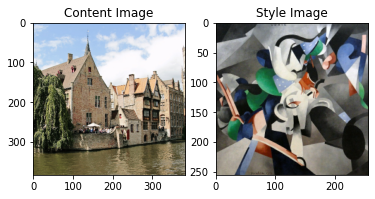

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

In [ ]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


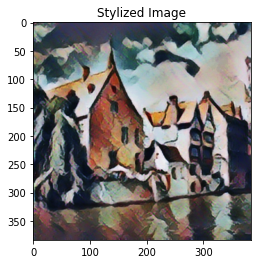

In [ ]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

In [ ]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

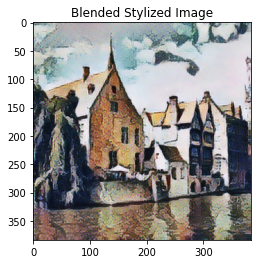

In [ ]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.56 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


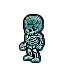

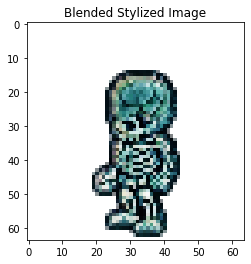

In [ ]:
content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/skeleton_64/sprite_14.png"
style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/blue_face.jpg"

# 원본 파일의 크기를 알 수 있게 하는 코드
origin_image = cv.imread(content_location, cv.IMREAD_UNCHANGED)
origin_image_shape = origin_image.shape

# Load the input images.
content_image = load_img(content_location)
style_image = load_img(style_location)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)

img_transformed = run_style_transform(style_bottleneck, preprocessed_content_image)

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
shape = preprocessed_content_image.shape[1]
x, y = shape, shape
origin_image_resized = cv.resize(origin_image, dsize=(y,x))

# alpha channel 추가
final = cv.cvtColor(img_transformed[0], cv.COLOR_RGB2RGBA)

final[:, :, 3] = origin_image_resized[:,:,3]

# final image 사이즈를 original image 사이즈로 변환
x, y = origin_image_shape[0], origin_image_shape[1]
final = cv.resize(final, dsize=(y,x))

# Visualize the output.
imshow(final, 'Blended Stylized Image')

# float to int 클리핑 (약간의 이미지 깨짐 현상 있음)
final = (final * 255).astype(np.uint)

# plt 기준의 bgr을 cv 기준의 rgb로 변경
b, g, r, a = cv.split(final)
final = cv.merge([r,g,b,a])

cv2_imshow(final)

In [ ]:
# 경로 설정 명세서
platform_path = platform.platform()

IsColab = "bionic" in platform_path
if IsColab:
  style_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/*"
  content_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/*"
  styled_location = "/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Styled_Images/"
else:
  style_location = 'Style_Images/*'
  content_location = "Content_Images/*"
  styled_location = "Styled_Images/"

# 해당 폴더 내에 존재하는 모든 폴더 리스트 불러오기
style_folder_list = glob.glob(style_location)
style_images_list = glob.glob(style_folder_list[0] + "/*")

# Style_location
# Style_Images/TEXTURE/*.jpg or png

# style_images_list, style_image 활용
# style_image = style_images_list[index]

# Content_location
  # Content_Images/ASSET_NAME/*.png
content_folder_list = glob.glob(content_location) # Content_Images/ASSET_NAME

# content_images_list, content_image 활용
# content_images_list = glob.glob(content_folder_list[index] + "/*")
# content_image = style_images_list[index]

# Styled_location
  # Styled_Images/ASSET_NAME/*.png
# asset_name = os.path.split(content_folder_list[index])

# 폴더 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

# 구글 코랩에서 장시간 사용하기
## F12 개발자 모드 후 Console에 입력



}

```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```


```javascript
function CleanCurrentOutput(){ 
    var btn = document.querySelector(".output-icon.clear_outputs_enabled.output-icon-selected[title$='현재 실행 중...'] iron-icon[command=clear-focused-or-selected-outputs]"); 
    if(btn) { console.log("30분마다 출력 지우기");
     btn.click(); 
    } 
} 
setInterval(CleanCurrentOutput,1000*60*30);
```

In [ ]:
## main code
import time
start = time.time()

# ★사용 모델명★
model_name = "inceptionV3(dynamic-shape)"

# 스타일 폴더 리스트
for SF_index, SF_value in enumerate(style_folder_list):
  style_images_list = glob.glob(style_folder_list[SF_index] + "/*")
  style_folder_name = os.path.split(style_folder_list[SF_index]) # horror, ice, dark .etc

  style_images_list = natsort.natsorted(style_images_list)

  # 스타일 이미지 리스트
  for SI_index, SI_value in enumerate(style_images_list):
    style_image_name = os.path.split(style_images_list[SI_index]) # horror1, horror2, horror3, .etc
    
    # 스타일 이미지 선택
    print(SI_value)
    style_image = load_img(SI_value)
    preprocessed_style_image = preprocess_image(style_image, 256)

    # 콘텐트 폴더 리스트
    for CF_index, CF_value in enumerate(content_folder_list):

      #콘텐트 이미지 리스트
      content_images_list = glob.glob(content_folder_list[CF_index] + "/*")
      content_images_list = natsort.natsorted(content_images_list)

      # 스타일 전이
      for CI_index, CI_value in enumerate(content_images_list):

        # 저장 경로 생성
        asset_folder = os.path.split(content_folder_list[CF_index]) # gobline, zombie, male .etc
        asset_name = os.path.split(CI_value)

        save_folder_model = styled_location + model_name
        save_folder_style = save_folder_model + "/" + style_folder_name[1]
        save_folder_style_index = save_folder_style + "/" + style_image_name[1]
        save_folder_style_index_content = save_folder_style_index + "/" + asset_folder[1]
        
        createFolder(save_folder_style) # VGG19, AdaIN, efficientNet
        createFolder(save_folder_style) # horror, ice, dark
        createFolder(save_folder_style_index) # horror1, horror2, horror3
        createFolder(save_folder_style_index_content) # goblin, zombie, male

        save_path = save_folder_style_index_content + "/"
        save_path = save_path + asset_name[1] + f'_{CI_index}_final.png'

        # 이미 있는 파일이면 건너뛰기
        if os.path.exists(save_path):
          continue
        else:
          try:
            # 원본 파일의 크기를 알 수 있게 하는 코드
            origin_image = cv.imread(CI_value, cv.IMREAD_UNCHANGED)
            origin_image_shape = origin_image.shape

            # Load the input images.
            content_image = load_img(CI_value)

            # Preprocess the input images.
            preprocessed_content_image = preprocess_image(content_image, 384)
          
            # Calculate style bottleneck for the preprocessed style image.
            style_bottleneck = run_style_predict(preprocessed_style_image)
            img_transformed = run_style_transform(style_bottleneck, preprocessed_content_image)

            # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
            shape = preprocessed_content_image.shape[1]
            x, y = shape, shape
            origin_image_resized = cv.resize(origin_image, dsize=(y,x))

            # alpha channel 추가
            final = cv.cvtColor(img_transformed[0], cv.COLOR_RGB2RGBA)
            final[:, :, 3] = origin_image_resized[:,:,3]

            # final image 사이즈를 original image 사이즈로 변환
            x, y = origin_image_shape[0], origin_image_shape[1]
            final = cv.resize(final, dsize=(y,x))

            # float to int 클리핑 (약간의 이미지 깨짐 현상 있음)
            final = (final * 255).astype(np.uint)

            # plt 기준의 bgr을 cv 기준의 rgb로 변경
            b, g, r, a = cv.split(final)
            final = cv.merge([r,g,b,a])
          
            # 저장
            cv.imwrite(save_path, final)
          except:
            print(CI_value)
            pass

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/blue_face.jpg
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/icicle_64/sprite_06.png
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/icicle_64/sprite_09.png
/content/drive/Shareddrives/SWTube/프로젝트/044. 2021 소융튜브 특성화 프로젝트/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/icicle_64/sprite_10.png
